In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, gaussian
import warnings                               
warnings.filterwarnings('ignore')

# 1. Plotting Waves

In [16]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)
we_have_gt = {key: dataframes[key] for key in dataframes.keys() & {'B1_1282_baseline', 'B2_1283_baseline', 'B2_1288_baseline'}}
len(we_have_gt)

3

In [18]:
df = pd.read_csv('ABR_exported_files/B1_1282_baseline.csv')

In [3]:
gt_data = {
    'B2_1283_baseline': {
        4000: {
            90: 0.0189,
            70: 0.00494
        },
        8000: {
            90: 0.01488,
            70: 0.01046
        },
        16000: {
            90: 0.02141,
            70: 0.01074
        },
        24000: {
            90: 0.02374,
            70: 0.01365
        },
        32000: {
            90: 0.02074,
            70: 0.01269
        }
    },
    'B2_1288_baseline': {
        4000: {
            90: 0.01338,
            70: 0.00057
        },
        8000: {
            90: 0.01093,
            70: 0.0014
        },
        16000: {
            90: 0.01667,
            70: 0.01044
        },
        24000: {
            90: 0.01504,
            70: 0.00747
        },
        32000: {
            90: 0.01421,
            70: 0.00444
        }
    },
    'B1_1282_baseline': {
        4000: {
            90: 0.02278,
            70: 0.0029
        },
        8000: {
            90: 0.02173,
            70: 0.0059
        },
        16000: {
            90: 0.03456,
            70: 0.02531
        },
        24000: {
            90: 0.03234,
            70: 0.01168
        },
        32000: {
            90: 0.02777,
            70: 0.00671
        }
    }
}

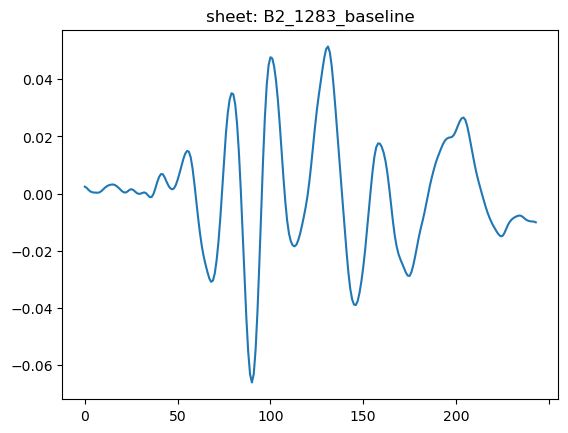

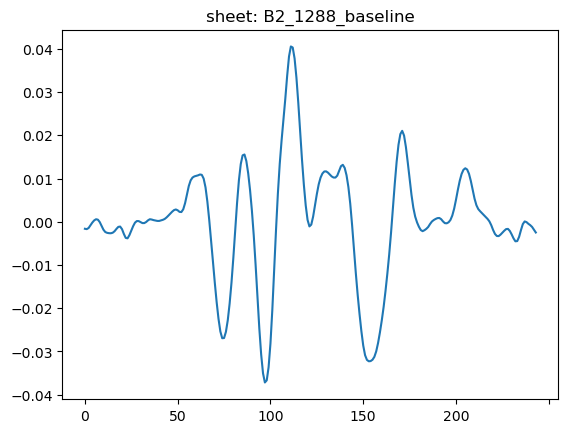

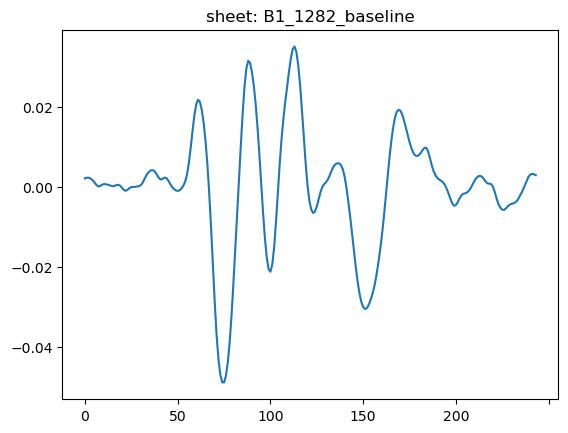

In [4]:
for filename, df in we_have_gt.items():
    khz = df[df['Freq(Hz)'] == 8000]
    dbkhz = khz[khz['Level(dB)'] == 90]
    index = dbkhz.index.values[0]
    final = df.iloc[index,48:]
    final = pd.to_numeric(final, errors='coerce')
    
    plt.figure()  
    final.plot()
    plt.title(f'sheet: {filename}') 
    plt.show()
    

# 2. Identifying Peaks

In [5]:
def plotting_waves(dataframes=we_have_gt, freq=16000, db=90, n=25):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        final = df.iloc[index, 48:]
        final = pd.to_numeric(final, errors='coerce')

        # Find highest peaks separated by at least n data points
        peaks, _ = find_peaks(final, distance=n)
        highest_peaks = peaks[np.argsort(final[peaks])[-5:]]

        loss_value = None
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_value = final[np.sort(highest_peaks)[0]]
            if gt_data.get(filename, {}).get(freq, {}).get(db) is not None:
                loss_value = (gt_data[filename][freq][db] - first_peak_value)**2

        plt.figure()
        plt.plot(final)
        
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak = np.sort(highest_peaks)[0]
            plt.plot([first_peak, first_peak], [final[first_peak], gt_data.get(filename, {}).get(freq, {}).get(db, np.nan)], "--", color='gray')
            plt.plot(first_peak, gt_data.get(filename, {}).get(freq, {}).get(db, np.nan), "o", color='blue', alpha = 0.5)

        x_ticks = np.arange(0, len(final), 20)
        plt.xticks(x_ticks)

        title = f'sheet: {filename}'
        if loss_value is not None:
            title += f', loss value = {loss_value}'

        plt.title(title)
        plt.plot(highest_peaks, final[highest_peaks], "x")
        print(loss_value)

        plt.show()

4.000000000001062e-12


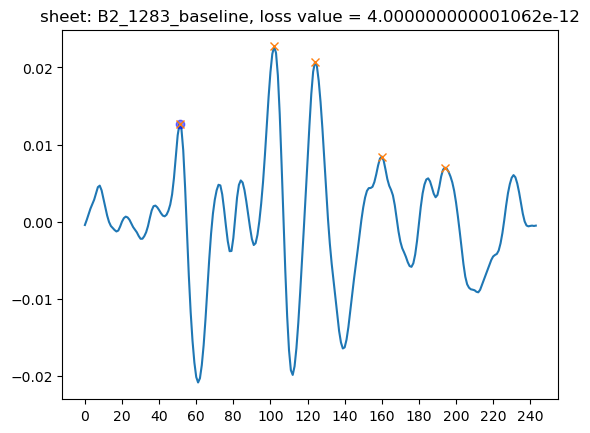

9.000000000002389e-12


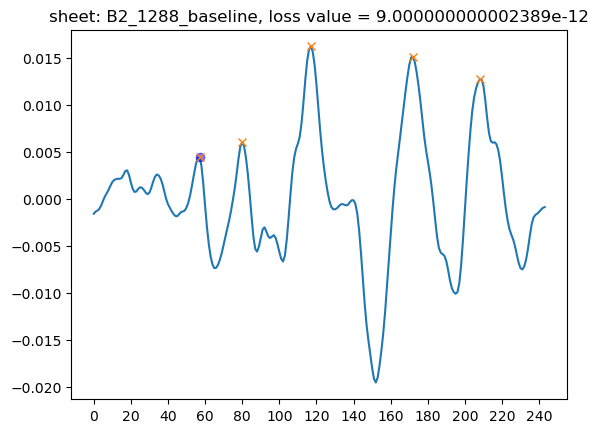

0.0


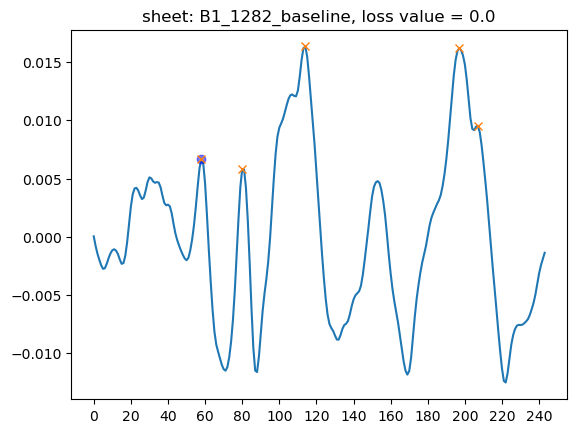

In [6]:
plotting_waves(freq=32000, db=70, n=9)

In [7]:
from sklearn.model_selection import KFold

def cross_validate(dataframes=we_have_gt, freq=16000, db=90, n_values=[20, 30, 40, 50], num_folds=3):
    overall_loss = {}

    for n in n_values:
        losses = []

        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(dataframes):
            train_data = {key: dataframes[key] for i, key in enumerate(dataframes) if i in train_index}
            test_data = {key: dataframes[key] for i, key in enumerate(dataframes) if i in test_index}

            for filename, df in test_data.items():
                khz = df[df['Freq(Hz)'] == freq]
                dbkhz = khz[khz['Level(dB)'] == db]
                index = dbkhz.index.values[0]
                final = df.iloc[index, 48:]
                final = pd.to_numeric(final, errors='coerce')

                # Find highest peaks separated by at least n data points
                peaks, _ = find_peaks(final, distance=n)
                highest_peaks = peaks[np.argsort(final[peaks])[-5:]]

                loss_value = None
                if gt_data.get(filename, {}).get(freq, {}).get(db) is not None and len(highest_peaks) > 0:
                    loss_value = (gt_data[filename][freq][db] - final[np.sort(highest_peaks)][0])**2
                    losses.append(loss_value)

        overall_loss[n] = np.mean(losses)

    best_n = min(overall_loss, key=overall_loss.get)

    return overall_loss, best_n

n_values = range(1,49)
overall_losses, best_n = cross_validate(n_values=n_values, num_folds=3, freq=32000, db=70)
print(f"Overall Losses: {overall_losses}")
print(f"Best n value: {best_n}")

Overall Losses: {1: 8.726426666666664e-07, 2: 8.726426666666664e-07, 3: 8.726426666666664e-07, 4: 8.726426666666664e-07, 5: 8.726426666666664e-07, 6: 8.726426666666664e-07, 7: 8.726426666666664e-07, 8: 8.726426666666664e-07, 9: 4.333333333334484e-12, 10: 4.333333333334484e-12, 11: 8.640376666666662e-07, 12: 8.640376666666662e-07, 13: 8.640376666666662e-07, 14: 8.640376666666662e-07, 15: 8.640376666666662e-07, 16: 8.640376666666662e-07, 17: 8.640376666666662e-07, 18: 8.640376666666662e-07, 19: 8.640376666666662e-07, 20: 8.640376666666662e-07, 21: 8.640376666666662e-07, 22: 8.640376666666662e-07, 23: 8.640376666666662e-07, 24: 1.5229800000000002e-06, 25: 1.5229800000000002e-06, 26: 1.5229800000000002e-06, 27: 1.5229800000000002e-06, 28: 1.5229800000000002e-06, 29: 2.762328e-06, 30: 2.762328e-06, 31: 2.762328e-06, 32: 2.762328e-06, 33: 2.762328e-06, 34: 2.762328e-06, 35: 2.4239902999999996e-05, 36: 4.2317842e-05, 37: 4.2317842e-05, 38: 4.2317842e-05, 39: 4.2317842e-05, 40: 4.3419164666666

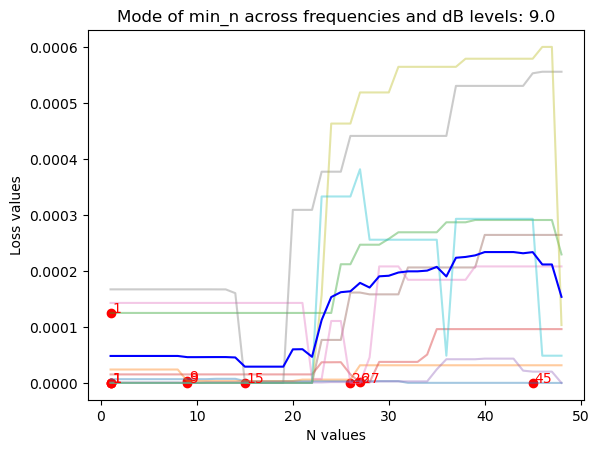

In [8]:
from statistics import mode

all_min_n_values = []
average_losses = {n: 0 for n in n_values}
num_combinations = 0

for db in (70, 90):
    for hz in (4000, 8000, 16000, 24000, 32000):
        overall_losses, best_n = cross_validate(n_values=n_values, num_folds=3, freq=hz, db=db)
        
        min_n = min(overall_losses, key=overall_losses.get)
        min_loss = overall_losses[min_n]
        all_min_n_values.append(min_n)

        for n, loss in overall_losses.items():
            average_losses[n] += loss

        num_combinations += 1

        plt.plot(overall_losses.keys(), overall_losses.values(), label=f'{hz} Hz, {db} dB', alpha = 0.4)
        plt.scatter(min_n, min_loss, color='red', marker='o')
        
        plt.annotate(f'{min_n}', xy=(min_n, min_loss), xytext=(min_n + 0.2, min_loss), color='red')

for n, average_loss in average_losses.items():
    average_losses[n] /= num_combinations

plt.plot(average_losses.keys(), average_losses.values(), label='Average Loss', color='blue')


overall_min_n_mode = np.median(all_min_n_values)
plt.title(f'Mode of min_n across frequencies and dB levels: {overall_min_n_mode}')

plt.xlabel('N values')
plt.ylabel('Loss values')
plt.show()


In [9]:
data = pd.read_csv('ABR_exported_files/A1_1293_24h PSI.csv', skiprows=2)
khz = data[data['Freq(Hz)'] == 16000]
dbkhz = khz[khz['Level(dB)'] == 90]
index = dbkhz.index.values[0]
final = data.iloc[index,48:]
final = pd.to_numeric(final, errors='coerce')

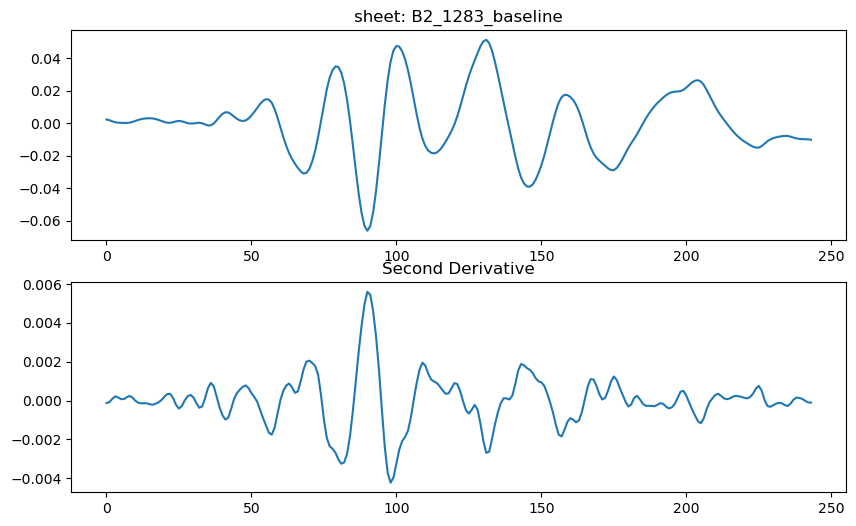

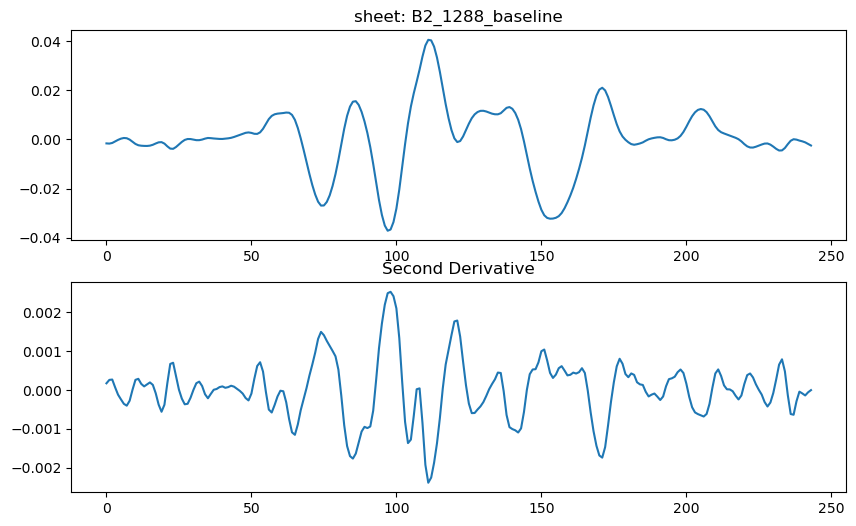

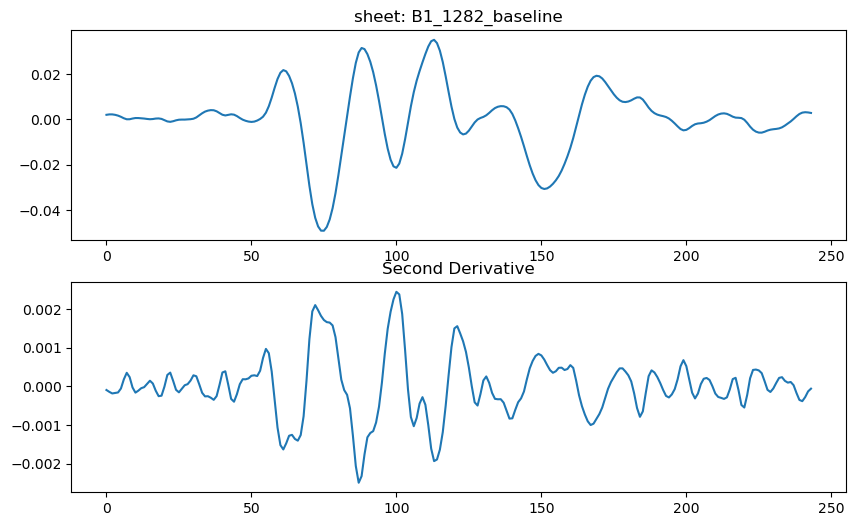

In [10]:
for filename, df in we_have_gt.items():
    khz = df[df['Freq(Hz)'] == 8000]
    dbkhz = khz[khz['Level(dB)'] == 90]
    index = dbkhz.index.values[0]
    final = df.iloc[index,48:]
    final = pd.to_numeric(final, errors='coerce')
    x = final.index.values[:-1].astype(int)
    dy_dx = np.gradient(final[:-1], final.index.values[:-1].astype(int))

    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, final.index.values[:-1].astype(int))

    # Plot the original data and the second derivative
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(x, final[:-1], label='Original Data')
    plt.title(f'sheet: {filename}')

    #plt.subplot(2, 1, 2)
    #plt.plot(x, dy_dx, label='First Derivative')
    #plt.title('First Derivative')

    plt.subplot(2, 1, 2)
    plt.plot(x, d2y_dx2, label='Second Derivative')
    plt.title('Second Derivative')

0.000207930873063565
[-0.00547195  0.00699019  0.0213937   0.033198    0.08446904]


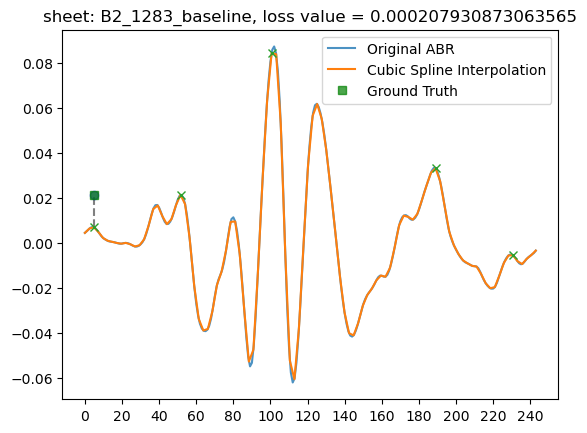

0.0002089349718666654
[0.00221542 0.00721365 0.01658611 0.02547355 0.086077  ]


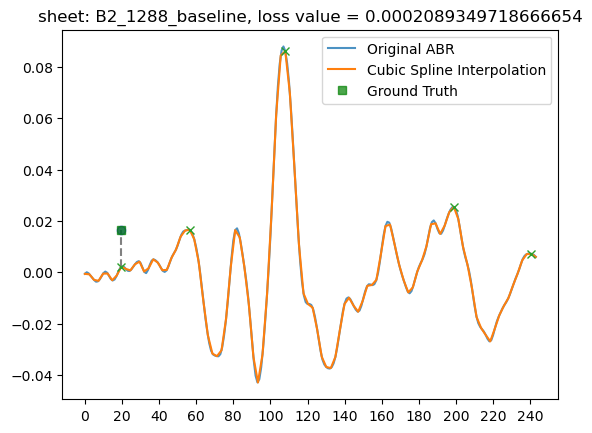

0.0011434530313287777
[0.00074502 0.00646212 0.02991205 0.0337247  0.083361  ]


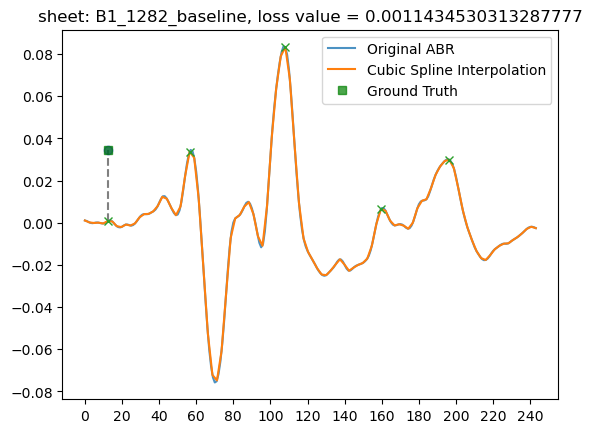

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def plotting_waves_cubic_spline(dataframes=we_have_gt, freq=16000, db=90, n=15):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        original_waveform = df.iloc[index, 48:]
        original_waveform = pd.to_numeric(original_waveform, errors='coerce')[:-1]

        # Apply cubic spline interpolation
        smooth_time = np.linspace(0, len(original_waveform) - 1, 100)
        cs = CubicSpline(np.arange(len(original_waveform)), original_waveform)
        smooth_amplitude = cs(smooth_time)

        # Find highest peaks separated by at least n data points in the smoothed curve
        peaks, _ = find_peaks(smooth_amplitude, distance=n)
        highest_peaks = peaks[np.argsort(smooth_amplitude[peaks])[-5:]]

        loss_value = None
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_value = smooth_amplitude[np.sort(highest_peaks)[0]]
            if gt_data.get(filename, {}).get(freq, {}).get(db) is not None:
                loss_value = (gt_data[filename][freq][db] - first_peak_value) ** 2

        plt.figure()
        
        # Plot the original ABR waveform
        plt.plot(np.arange(len(original_waveform)), original_waveform, label='Original ABR', alpha=0.8)

        # Plot the cubic spline interpolation
        plt.plot(smooth_time, smooth_amplitude, label='Cubic Spline Interpolation')

        if highest_peaks.size > 0:
            first_peak = np.sort(highest_peaks)[0]
            plt.plot([smooth_time[first_peak], smooth_time[first_peak]], [smooth_amplitude[first_peak], gt_data.get(filename, {}).get(freq, {}).get(db, np.nan)], "--", color='gray')
            plt.plot(smooth_time[first_peak], gt_data.get(filename, {}).get(freq, {}).get(db, np.nan), "o", color='blue', alpha=0.5)

        x_ticks = np.arange(0, len(original_waveform), 20)
        plt.xticks(x_ticks)

        title = f'sheet: {filename}'
        if loss_value is not None:
            title += f', loss value = {loss_value}'

        plt.title(title)
        plt.plot(smooth_time[highest_peaks], smooth_amplitude[highest_peaks], "x")
        print(loss_value)
        print(smooth_amplitude[highest_peaks])

        # Compare to ground truth
        gt_value = gt_data.get(filename, {}).get(freq, {}).get(db)
        if gt_value is not None:
            plt.plot([smooth_time[first_peak]], [gt_value], "s", color='green', label='Ground Truth', alpha=0.7)

        plt.legend()
        plt.show()

plotting_waves_cubic_spline()

In [12]:
for filename, df in we_have_gt.items():
        khz = df[df['Freq(Hz)'] == 16000]
        dbkhz = khz[khz['Level(dB)'] == 90]
        index = dbkhz.index.values[0]
        final = df.iloc[index, 48:]
        final = pd.to_numeric(final, errors='coerce')

In [13]:
final[:-1]

0      0.001070
1      0.000816
2      0.000346
3     -0.000057
4     -0.000207
         ...   
239   -0.002348
240   -0.001990
241   -0.001900
242   -0.002131
243   -0.002557
Name: 23, Length: 244, dtype: float64

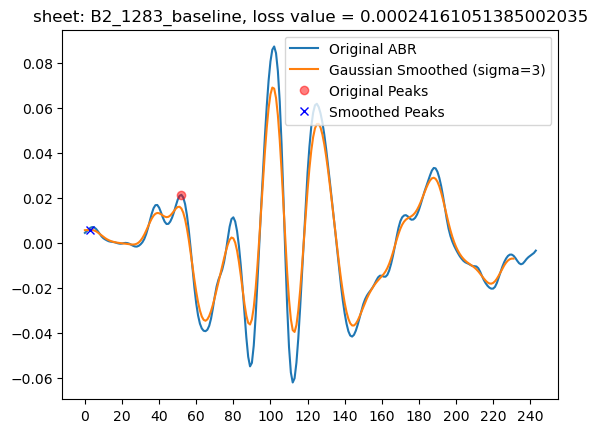

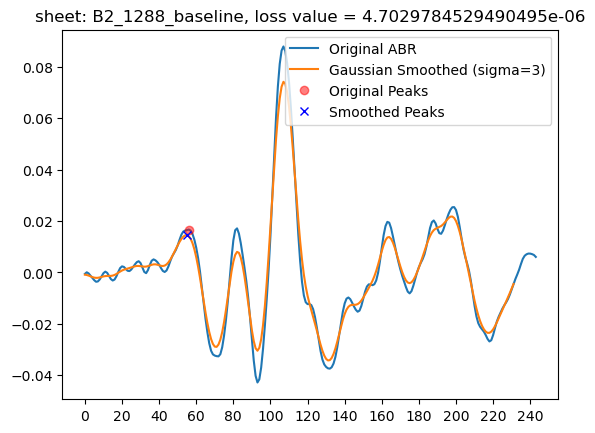

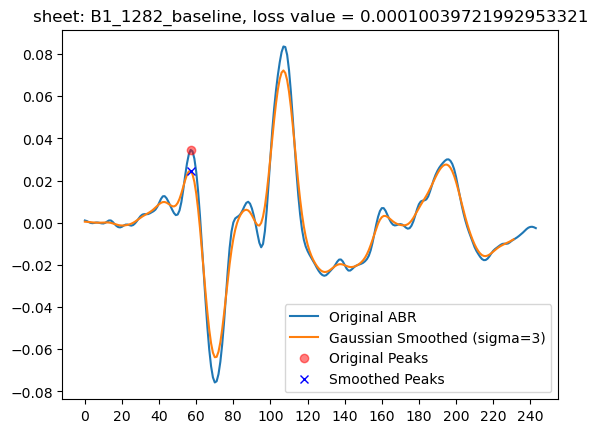

In [14]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def plotting_waves_gauss(dataframes=we_have_gt, freq=16000, db=90, n=15, sigma=3):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        original_waveform = df.iloc[index, 48:]
        original_waveform = pd.to_numeric(original_waveform, errors='coerce')

        # Apply Gaussian smoothing to the original ABR waveform
        smoothed_waveform = gaussian_filter1d(original_waveform, sigma=sigma)

        # Find highest peaks separated by at least n data points in the original curve
        original_peaks, _ = find_peaks(original_waveform, distance=n)
        highest_original_peaks = original_peaks[np.argsort(original_waveform[original_peaks])[-5:]]

        # Find highest peaks separated by at least n data points in the smoothed curve
        smoothed_peaks, _ = find_peaks(smoothed_waveform, distance=n)
        highest_smoothed_peaks = smoothed_peaks[np.argsort(smoothed_waveform[smoothed_peaks])[-5:]]

        loss_value = None
        if highest_smoothed_peaks.size > 0:  # Check if highest_smoothed_peaks is not empty
            first_peak_value = smoothed_waveform[np.sort(highest_smoothed_peaks)[0]]
            if gt_data.get(filename, {}).get(freq, {}).get(db) is not None:
                loss_value = (gt_data[filename][freq][db] - first_peak_value) ** 2

        plt.figure()

        # Plot the original ABR waveform
        plt.plot(original_waveform, label='Original ABR')

        # Plot the smoothed ABR waveform
        plt.plot(smoothed_waveform, label=f'Gaussian Smoothed (sigma={sigma})')

        if highest_original_peaks.size > 0:  # Check if highest_original_peaks is not empty
            first_original_peak = np.sort(highest_original_peaks)[0]
            plt.plot(first_original_peak, original_waveform[first_original_peak], "o", color='red', label='Original Peaks', alpha=0.5)

        if highest_smoothed_peaks.size > 0:  # Check if highest_smoothed_peaks is not empty
            first_smoothed_peak = np.sort(highest_smoothed_peaks)[0]
            plt.plot(first_smoothed_peak, smoothed_waveform[first_smoothed_peak], "x", label='Smoothed Peaks', color='blue')

        x_ticks = np.arange(0, len(original_waveform), 20)
        plt.xticks(x_ticks)

        title = f'sheet: {filename}'
        if loss_value is not None:
            title += f', loss value = {loss_value}'

        plt.title(title)
        plt.legend()
        plt.show()

plotting_waves_gauss()
